In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Loading functions
import os
import time
from monai.data import DataLoader, decollate_batch
import torch
import torch.nn.parallel

from src.get_data import CustomDataset, CustomDatasetSeg
import numpy as np
from scipy import ndimage
from types import SimpleNamespace
import wandb
import logging

#####
import json
import shutil
import tempfile

import matplotlib.pyplot as plt
import nibabel as nib

from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai import transforms
from monai.transforms import (
    AsDiscrete,
    Activations,
    MapTransform,
    Transform,
)

from monai.config import print_config
from monai.metrics import DiceMetric
from monai.utils.enums import MetricReduction
from monai.networks.nets import SwinUNETR
from monai import data

# from monai.data import decollate_batch
from functools import partial
from src.custom_transforms import (ConvertToMultiChannelBasedOnN_Froi, 
                                   ConvertToMultiChannelBasedOnAnotatedInfiltration, 
                                   masked, ConvertToMultiChannelBasedOnBratsClassesdI)

## Configure Trasnformations

In [3]:
roi = (128, 128, 128) # (220, 220, 155) (128, 128, 64)
source_k="label"
train_transform = transforms.Compose(
    [
        transforms.LoadImaged(keys=["image", "label"]),
        # ConvertToMultiChannelBasedOnAnotatedInfiltration(keys="label"), # Use in Pipeline 2
        ConvertToMultiChannelBasedOnBratsClassesdI(keys="label"), # Use in Pipeline 1 or Combined
        transforms.CropForegroundd(
            keys=["image", "label"],
            source_key=source_k,
            k_divisible=[roi[0], roi[1], roi[2]],
        ),
        transforms.RandSpatialCropd(
            keys=["image", "label"],
            roi_size=[roi[0], roi[1], roi[2]],
            random_size=False,
        ),
        transforms.NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
        
    ]
)
val_transform = transforms.Compose(
    [
        transforms.LoadImaged(keys=["image", "label"]),
        # ConvertToMultiChannelBasedOnAnotatedInfiltration(keys="label"), # Use in Pipeline 2
        ConvertToMultiChannelBasedOnBratsClassesdI(keys="label"), # Use in Pipeline 1 or Combined
        transforms.RandSpatialCropd(
            keys=["image", "label"],
            roi_size=[-1, -1, -1], #[224, 224, 128],
            random_size=False,
        ),
        transforms.NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
    ]
)

/home/minigo/anaconda3/envs/monai_env/lib/python3.11/site-packages/monai/utils/deprecate_utils.py:321: FutureWarning: monai.transforms.croppad.dictionary CropForegroundd.__init__:allow_smaller: Current default value of argument `allow_smaller=True` has been deprecated since version 1.2. It will be changed to `allow_smaller=False` in version 1.5.
  warn_deprecated(argname, msg, warning_category)


## Define SwinUNETR architecture

In [4]:
######################
# Crear el modelo
######################

### Hyperparameter
roi = (128, 128, 128)  

# Create Swin transformer
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def define_model(model_path):
    model = SwinUNETR(
        img_size=roi,
        in_channels=11, 
        out_channels=2,  
        feature_size=48, 
        drop_rate=0.0,
        attn_drop_rate=0.0,
        dropout_path_rate=0.0,
        use_checkpoint=True,
    )

    loaded_model = torch.load(model_path, map_location=torch.device('cuda:0'), weights_only=False)["state_dict"]

    # Load the state dictionary into the model
    model.load_state_dict(loaded_model)
    return model
    

## Load SwinUNETR models weights
You need to have the models.pt in ./trained_models

In [5]:
# Model Tumor Core + Edema
model1=define_model("trained_models/vtzpbajf_best_model_pipe1/model.pt") 
model1.to(device)
model1.eval()

# Model Infiltration + Edema
model2=define_model("trained_models/1dhzmigz_best_model_pipe2/model.pt") 
model2.to(device)
model2.eval()

/home/minigo/anaconda3/envs/monai_env/lib/python3.11/site-packages/monai/utils/deprecate_utils.py:221: FutureWarning: monai.networks.nets.swin_unetr SwinUNETR.__init__:img_size: Argument `img_size` has been deprecated since version 1.3. It will be removed in version 1.5. The img_size argument is not required anymore and checks on the input size are run during forward().
  warn_deprecated(argname, msg, warning_category)


SwinUNETR(
  (swinViT): SwinTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv3d(11, 48, kernel_size=(2, 2, 2), stride=(2, 2, 2))
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (layers1): ModuleList(
      (0): BasicLayer(
        (blocks): ModuleList(
          (0-1): 2 x SwinTransformerBlock(
            (norm1): LayerNorm((48,), eps=1e-05, elementwise_affine=True)
            (attn): WindowAttention(
              (qkv): Linear(in_features=48, out_features=144, bias=True)
              (attn_drop): Dropout(p=0.0, inplace=False)
              (proj): Linear(in_features=48, out_features=48, bias=True)
              (proj_drop): Dropout(p=0.0, inplace=False)
              (softmax): Softmax(dim=-1)
            )
            (drop_path): Identity()
            (norm2): LayerNorm((48,), eps=1e-05, elementwise_affine=True)
            (mlp): MLPBlock(
              (linear1): Linear(in_features=48, out_features=192, bias=True)
              (linear2): Linear(in_featur

# Run inference and save MRIs

In [6]:

import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from monai import transforms
import nibabel as nib
import matplotlib.pyplot as plt
import monai.utils
from src.get_data import CustomDatasetRec

# Dispositivo
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


# Modelo de proyección (MLP más profundo)
class ProjectionHead(nn.Module):
    def __init__(self, input_dim=48, hidden_dim1=256, hidden_dim2=128, output_dim=128, dropout_p=0.3):
        super(ProjectionHead, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim1),
            nn.ReLU(),
            nn.Linear(hidden_dim1, hidden_dim2),
            nn.ReLU(),
            nn.Linear(hidden_dim2, output_dim)
        )
    
    def forward(self, x):
        return self.net(x)


# Clasificador supervisado (MLP)
class Classifier(nn.Module):
    def __init__(self, input_dim=128, hidden_dim1=256, hidden_dim2=128, num_classes=3, dropout_p=0.3):
        super(Classifier, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim1),
            nn.ReLU(),
            nn.Linear(hidden_dim1, hidden_dim2),
            nn.ReLU(),
            nn.Linear(hidden_dim2, num_classes)
        )
    
    def forward(self, x):
        return self.net(x)

# Función para generar mapas de probabilidad
def generate_probability_maps(embeddings, projection_head, classifier, device, batch_size=8192):
    projection_head.eval()
    classifier.eval()
    with torch.no_grad():
        embeddings = embeddings.squeeze(0).permute(1, 2, 3, 0)  # [128, 128, 128, 48]
        embeddings_flat = embeddings.reshape(-1, 48)  # [2097152, 48]
        probs_flat = []
        
        for i in range(0, embeddings_flat.shape[0], batch_size):
            batch = embeddings_flat[i:i+batch_size].to(device)
            z = projection_head(batch)  # [batch_size, 128]
            z = F.normalize(z, dim=1)
            logits = classifier(z)  # [batch_size, 3]
            probs = F.softmax(logits, dim=1)  # [batch_size, 3]
            probs_flat.append(probs.cpu())
        
        probs_flat = torch.cat(probs_flat, dim=0)  # [2097152, 3]
        probs = probs_flat.reshape(128, 128, 128, 3)  # [128, 128, 128, 3]
        probs = probs.permute(3, 0, 1, 2)  # [3, 128, 128, 128]
    
    return probs  # Tensor [3, 128, 128, 128]

# Transformaciones de MONAI ajsutadas para añadir recurrencia
roi = (128, 128, 128)
source_k = "label"
combined_transform = transforms.Compose(
    [
        transforms.LoadImaged(keys=["image", "label", "recurrence"]),
        transforms.EnsureChannelFirstD(keys="recurrence"),
        ConvertToMultiChannelBasedOnBratsClassesdI(keys="label"), # Use in Pipeline 1 or Combined
        # ConvertToMultiChannelBasedOnAnotatedInfiltration(keys="label"), # Use in Pipeline 2
        transforms.CropForegroundd(
            keys=["image", "label", "recurrence"],
            source_key="label",
            k_divisible=[128, 128, 128],
        ),
        transforms.RandSpatialCropd(
            keys=["image", "label", "recurrence"],
            roi_size=[128, 128, 128],
            random_size=False,
        ),
        transforms.NormalizeIntensityd(keys=["image", "recurrence"], nonzero=True, channel_wise=True),
    ]
)

# Dataset y DataLoader
dataset_path = './Dataset'
train_set = CustomDatasetRec(dataset_path, section="test_6", transform=combined_transform)
train_loader = DataLoader(train_set, batch_size=1, shuffle=False, num_workers=0)

# Directorios
output_dir = "Datatest/MRIs/combined_results_recurrencia_pipe1-pipe2_test6"
nifti_output_dir = os.path.join(output_dir, "nifti_volumes")
probs_output_dir = os.path.join(output_dir, "probability_maps")
os.makedirs(output_dir, exist_ok=True)
os.makedirs(nifti_output_dir, exist_ok=True)
os.makedirs(probs_output_dir, exist_ok=True)

# Cargar modelos contrastivos preentrenados
projection_head1 = ProjectionHead(input_dim=48).to(device)
projection_head1.load_state_dict(torch.load("trained_models/contrastive_projection_head_final_new_pipe1_v01_m1.pth", map_location=device))
# projection_head1.eval()

projection_head2 = ProjectionHead(input_dim=48).to(device)
projection_head2.load_state_dict(torch.load("trained_models/contrastive_projection_head_final_new_pipe2_m1_1dhzmigz.pth", map_location=device))
# projection_head2.eval()

# Cargar clasificadores preentrenados
classifier1 = Classifier(input_dim=128, num_classes=3).to(device)
classifier1.load_state_dict(torch.load("trained_models/supervised_classifier_final_pipe1_v01_m1.pth", map_location=device))
# classifier1.eval()

classifier2 = Classifier(input_dim=128, num_classes=3).to(device)
classifier2.load_state_dict(torch.load("trained_models/supervised_classifier_final_pipe2_m1_1dhzmigz.pth", map_location=device))

# classifier2.eval()

# Hooks para embeddings
decoder_features_model1 = None
decoder_features_model2 = None

def decoder_hook_fn_model1(module, input, output):
    global decoder_features_model1
    decoder_features_model1 = output

def decoder_hook_fn_model2(module, input, output):
    global decoder_features_model2
    decoder_features_model2 = output

hook_handle_decoder1 = model1.decoder1.conv_block.register_forward_hook(decoder_hook_fn_model1)
hook_handle_decoder2 = model2.decoder1.conv_block.register_forward_hook(decoder_hook_fn_model2)


# Procesar y combinar
with torch.no_grad():
    for idx, batch_data in enumerate(train_loader):
        monai.utils.set_determinism(seed=idx)
        
        print(f"\nCaso {idx}:")
        print(f"image shape: {batch_data['image'].shape}")
        print(f"label shape: {batch_data['label'].shape}")
        print(f"recurrence shape: {batch_data['recurrence'].shape}")
        
        # Extraer datos
        # Obtener imágenes y metadatos
        image, label = batch_data["image"], batch_data["label"]  # [1, 11, 128, 128, 128], [1, 2, 128, 128, 128]
        image_meta = batch_data["image"].meta
        affine = image_meta.get("affine", np.eye(4)).numpy()

        image = image.to(device)  # [1, 11, 128, 128, 128]
        label = label.to(device)  # [1, 2, 128, 128, 128]
        recurrence = batch_data["recurrence"].to(device)  # [1, 1, 128, 128, 128]
                
        # Convertir recurrencia a numpy
        recurrence_np = recurrence.squeeze().cpu().numpy().astype(np.float32)  # [128, 128, 128]
        print(f"Caso {idx}: recurrence_np shape: {recurrence_np.shape}, min: {recurrence_np.min()}, max: {recurrence_np.max()}, mean: {recurrence_np.mean()}")
        
        # Debug: Verificar canales one-hot
        print(f"Caso {idx}: Vasogénico channel sum (6): {label[0, 0].sum().item()}, Infiltrado channel sum (2): {label[0, 1].sum().item()}")
        
        # Convertir one-hot a etiquetas únicas (0, 6, 2)
        label_class = torch.zeros(label.shape[2:], dtype=torch.long, device=device)  # [128, 128, 128]
        label_class[label[0, 0] == 1] = 6  # Vasogénico
        label_class[label[0, 1] == 1] = 2  # Infiltrado
        labels_np = label_class.cpu().numpy().astype(np.int16)  # [128, 128, 128]
        
        # Mapear etiquetas a 0, 1, 2 para métricas
        labels_metrics = np.zeros_like(labels_np, dtype=np.int16)
        labels_metrics[labels_np == 6] = 1  # Vasogénico -> 1
        labels_metrics[labels_np == 2] = 2  # Infiltrado -> 2
        
        # Verificar etiquetas
        unique_labels = np.unique(labels_np)
        print(f"Caso {idx}: Etiquetas únicas (0, 2, 6): {unique_labels}")
        if not np.all(np.isin(unique_labels, [0, 2, 6])):
            print(f"Advertencia: Etiquetas inválidas en caso {idx}: {unique_labels}")
        if 6 not in unique_labels:
            print(f"Advertencia: Clase vasogénico (6) no presente en caso {idx}")
        
        # Obtener embeddings
        _ = model1(image)
        _ = model2(image)
        embeddings1 = decoder_features_model1
        embeddings2 = decoder_features_model2
        
        # Generar mapas de probabilidad
        prob_maps1 = generate_probability_maps(embeddings1, projection_head1, classifier1, device)  # [3, 128, 128, 128]
        prob_maps2 = generate_probability_maps(embeddings2, projection_head2, classifier2, device)  # [3, 128, 128, 128]
        
        # Combinar mapas
        combined_prob_maps = torch.zeros_like(prob_maps1)  # [3, 128, 128, 128]
        combined_prob_maps[0] = prob_maps1[0]  # Fondo (0)
        combined_prob_maps[1] = torch.max(prob_maps1[1], prob_maps2[1])  # Vasogénico (1)
        combined_prob_maps[2] = prob_maps2[2]  # Infiltrado (2)
        
        # Normalizar probabilidades
        combined_prob_maps = combined_prob_maps / (combined_prob_maps.sum(dim=0, keepdim=True) + 1e-6)
        
        # Convertir a numpy
        prob_maps_np = combined_prob_maps.cpu().numpy()  # [3, 128, 128, 128]
        prob_maps_np_nifti = np.transpose(prob_maps_np, (1, 2, 3, 0))  # [128, 128, 128, 3]
        
        # Generar segmentación semántica (clases 0, 1, 2)
        segmentation = np.argmax(prob_maps_np, axis=0)  # [128, 128, 128]
        segmentation_np = segmentation.astype(np.int16)  # [0, 1, 2]
        
        # Mapear segmentación a valores originales (0, 6, 2)
        segmentation_np_orig = np.zeros_like(segmentation_np, dtype=np.int16)
        segmentation_np_orig[segmentation_np == 1] = 6  # Vasogénico
        segmentation_np_orig[segmentation_np == 2] = 2  # Infiltrado
        
        # Guardar imágenes MRI en NIfTI
        image_np = image.squeeze(0).cpu().numpy()  # [11, 128, 128, 128]
        for channel in range(image_np.shape[0]):
            nifti_img = nib.Nifti1Image(image_np[channel], affine, header=nib.Nifti1Header())
            nib.save(nifti_img, os.path.join(nifti_output_dir, f"case_{idx}_modality_{channel}.nii.gz"))
        
        # Guardar imagen de recurrencia en NIfTI
        nifti_recurrence_img = nib.Nifti1Image(recurrence_np, affine, header=nib.Nifti1Header())
        recurrence_output_path = os.path.join(nifti_output_dir, f"case_{idx}_recurrence.nii.gz")
        nib.save(nifti_recurrence_img, recurrence_output_path)
        print(f"Guardada imagen de recurrencia en {recurrence_output_path}")
        saved_nifti = nib.load(recurrence_output_path)
        saved_data = saved_nifti.get_fdata()
        print(f"Saved recurrence NIfTI shape: {saved_data.shape}, min: {saved_data.min()}, max: {saved_data.max()}, mean: {saved_data.mean()}")
        file_size = os.path.getsize(recurrence_output_path) / 1024  # Size in kB
        print(f"Recurrence file size: {file_size:.2f} kB")
        
        # Guardar etiquetas en NIfTI (valores 0, 2, 6)
        nifti_label_img = nib.Nifti1Image(labels_np, affine, header=nib.Nifti1Header())
        label_output_path = os.path.join(nifti_output_dir, f"labels_case_{idx}.nii.gz")
        nib.save(nifti_label_img, label_output_path)
        print(f"Guardadas etiquetas en {label_output_path}")
        
        # Guardar mapas de probabilidad
        nifti_prob_img = nib.Nifti1Image(prob_maps_np_nifti, affine, header=nib.Nifti1Header())
        prob_output_path = os.path.join(probs_output_dir, f"probability_maps_case_{idx}.nii.gz")
        nib.save(nifti_prob_img, prob_output_path)
        print(f"Guardado mapa de probabilidad en {prob_output_path}")
        
        # Guardar segmentación (valores 0, 6, 2)
        nifti_seg_img = nib.Nifti1Image(segmentation_np_orig, affine, header=nib.Nifti1Header())
        seg_output_path = os.path.join(nifti_output_dir, f"segmentation_case_{idx}.nii.gz")
        nib.save(nifti_seg_img, seg_output_path)
        print(f"Guardada segmentación en {seg_output_path}")
        
        # Restaurar aleatoriedad después de cada caso
        monai.utils.set_determinism(seed=None)

# Remover hooks
hook_handle_decoder1.remove()
hook_handle_decoder2.remove()

Found 6 images, 6 labels, and 6 recurrence files.
2025-12-11 14:47:20,979 - INFO - Apply pending transforms - lazy: None, pending: 0, upcoming 'Compose', transform.lazy: False
After transforms - image shape: torch.Size([11, 128, 128, 128]), label shape: torch.Size([2, 128, 128, 128]), recurrence shape: torch.Size([1, 128, 128, 128])

Caso 0:
image shape: torch.Size([1, 11, 128, 128, 128])
label shape: torch.Size([1, 2, 128, 128, 128])
recurrence shape: torch.Size([1, 1, 128, 128, 128])
Caso 0: recurrence_np shape: (128, 128, 128), min: -2.4518356323242188, max: 10.343467712402344, mean: 1.5454133972525597e-08
Caso 0: Vasogénico channel sum (6): 40406, Infiltrado channel sum (2): 22403
Caso 0: Etiquetas únicas (0, 2, 6): [0 2 6]
Guardada imagen de recurrencia en Datatest/MRIs/combined_results_recurrencia_pipe1-pipe2_test6/nifti_volumes/case_0_recurrence.nii.gz
Saved recurrence NIfTI shape: (128, 128, 128), min: -2.4518356323242188, max: 10.343467712402344, mean: 1.4600035069811668e-08
R

## Obtain embeddings and store them to calculate metrics

In [7]:
# Create dataset data loader
# dataset_path='./Dataset/Dataset_recurrence'
dataset_path='./Dataset'
train_set=CustomDataset(dataset_path, section="test_6", transform=train_transform) # v_transform / test_6_1out
train_loader = DataLoader(train_set, batch_size=1, shuffle=False, num_workers=1)

# Directorios para embeddings de cada modelo
embedding_dir_model1 = "Datatest/contrastive_voxel_wise/embeddings_model1"
embedding_dir_model2 = "Datatest/contrastive_voxel_wise/embeddings_model2"
label_output_dir = "Datatest/contrastive_voxel_wise/labels"

# Crear carpetas si no existen
os.makedirs(embedding_dir_model1, exist_ok=True)
os.makedirs(embedding_dir_model2, exist_ok=True)
os.makedirs(label_output_dir, exist_ok=True)

# Variables para las características de los decoders de ambos modelos
decoder_features_model1 = None
decoder_features_model2 = None

# Funciones hook para cada modelo
def decoder_hook_fn_model1(module, input, output):
    global decoder_features_model1
    decoder_features_model1 = output

def decoder_hook_fn_model2(module, input, output):
    global decoder_features_model2
    decoder_features_model2 = output

# Registrar los hooks en los decoders de ambos modelos
hook_handle_decoder1 = model1.decoder1.conv_block.register_forward_hook(decoder_hook_fn_model1)
hook_handle_decoder2 = model2.decoder1.conv_block.register_forward_hook(decoder_hook_fn_model2)

# Extraer y guardar
with torch.no_grad():
    for idx, batch_data in enumerate(train_loader):
        image, label = batch_data["image"], batch_data["label"]
        print("Image", image.shape)  # [1, 11, 128, 128, 128]
        print("label before squeeze", label.shape)  # [1, 2, 128, 128, 128]
        
        image = image.to(device)
        label = label.squeeze(0)  # [2, 128, 128, 128]
        
        # Convertir one-hot a etiquetas únicas
        label_sum = label.sum(dim=0)  # [128, 128, 128], suma de canales
        label_class = torch.zeros_like(label_sum, dtype=torch.long)  # [128, 128, 128]
        
        # Asignar clases:
        label_class[label[1] == 1] = 2  # Infiltrado
        label_class[(label[0] == 1) & (label[1] == 0)] = 1  # Vasogénico
        # Donde label_sum == 0, ya es fondo (0)
        
        label = label_class.cpu().numpy()  # [128, 128, 128]
        print("label", label.shape)
        
        # Obtener embeddings de ambos modelos
        _ = model1(image)  # Forward para model1
        print("decoder_features_model1:", decoder_features_model1.shape)  # [1, 48, 128, 128, 128]
        
        _ = model2(image)  # Forward para model2
        print("decoder_features_model2:", decoder_features_model2.shape)  # [1, 48, 128, 128, 128]
        
        # Guardar embeddings y etiquetas
        np.save(f"{embedding_dir_model1}/case_{idx}.npy", decoder_features_model1.cpu().numpy())
        np.save(f"{embedding_dir_model2}/case_{idx}.npy", decoder_features_model2.cpu().numpy())
        np.save(f"{label_output_dir}/case_{idx}.npy", label)
        
        print(f"Guardado embeddings y etiquetas para caso {idx}")

# Remover los hooks
hook_handle_decoder1.remove()
hook_handle_decoder2.remove()

Found 6 images and 6 labels.
Image torch.Size([1, 11, 128, 128, 128])
label before squeeze torch.Size([1, 2, 128, 128, 128])
label (128, 128, 128)
decoder_features_model1: torch.Size([1, 48, 128, 128, 128])
decoder_features_model2: torch.Size([1, 48, 128, 128, 128])
Guardado embeddings y etiquetas para caso 0
Image torch.Size([1, 11, 128, 128, 128])
label before squeeze torch.Size([1, 2, 128, 128, 128])
label (128, 128, 128)
decoder_features_model1: torch.Size([1, 48, 128, 128, 128])
decoder_features_model2: torch.Size([1, 48, 128, 128, 128])
Guardado embeddings y etiquetas para caso 1
Image torch.Size([1, 11, 128, 128, 128])
label before squeeze torch.Size([1, 2, 128, 128, 128])
label (128, 128, 128)
decoder_features_model1: torch.Size([1, 48, 128, 128, 128])
decoder_features_model2: torch.Size([1, 48, 128, 128, 128])
Guardado embeddings y etiquetas para caso 2
Image torch.Size([1, 11, 128, 128, 128])
label before squeeze torch.Size([1, 2, 128, 128, 128])
label (128, 128, 128)
decoder

## Running Evaluation
We can restart the notebook kernel since it is not necessary to use the SwinUNETR models without the embeddings obtained previously

In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import nibabel as nib
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, f1_score
import matplotlib.pyplot as plt

# Dispositivo
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Dataset (ya lo tienes)
class EmbeddingDataset(Dataset):
    def __init__(self, embedding_dir, label_dir):
        self.embedding_dir = embedding_dir
        self.label_dir = label_dir
        self.case_files = [f for f in os.listdir(embedding_dir) if f.endswith(".npy")]
        
    def __len__(self):
        return len(self.case_files)
    
    def __getitem__(self, idx):
        embedding_path = os.path.join(self.embedding_dir, f"case_{idx}.npy")
        label_path = os.path.join(self.label_dir, f"case_{idx}.npy")
        
        embeddings = np.load(embedding_path)  # [1, 48, 128, 128, 128]
        labels = np.load(label_path)  # [128, 128, 128]
        
        embeddings = torch.tensor(embeddings, dtype=torch.float32).squeeze(0)  # [48, 128, 128, 128]
        labels = torch.tensor(labels, dtype=torch.long)  # [128, 128, 128]
        
        return embeddings, labels


# Modelo de proyección (MLP más profundo)
class ProjectionHead(nn.Module):
    def __init__(self, input_dim=48, hidden_dim1=256, hidden_dim2=128, output_dim=128, dropout_p=0.3):
        super(ProjectionHead, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim1),
            nn.ReLU(),
            nn.Linear(hidden_dim1, hidden_dim2),
            nn.ReLU(),
            nn.Linear(hidden_dim2, output_dim)
        )
    
    def forward(self, x):
        return self.net(x)


# Clasificador supervisado (MLP)
class Classifier(nn.Module):
    def __init__(self, input_dim=128, hidden_dim1=256, hidden_dim2=128, num_classes=3, dropout_p=0.3):
        super(Classifier, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim1),
            nn.ReLU(),
            nn.Linear(hidden_dim1, hidden_dim2),
            nn.ReLU(),
            nn.Linear(hidden_dim2, num_classes)
        )
    
    def forward(self, x):
        return self.net(x)

# Configuración para ambos modelos
embedding_dir_model1 = "Datatest/contrastive_voxel_wise/embeddings_model1"
embedding_dir_model2 = "Datatest/contrastive_voxel_wise/embeddings_model2"
label_dir = "Datatest/contrastive_voxel_wise/labels"
batch_size = 1

# Cargar datasets y DataLoaders para ambos modelos
dataset_model1 = EmbeddingDataset(embedding_dir_model1, label_dir)
dataset_model2 = EmbeddingDataset(embedding_dir_model2, label_dir)
loader_model1 = DataLoader(dataset_model1, batch_size=batch_size, shuffle=False)
loader_model2 = DataLoader(dataset_model2, batch_size=batch_size, shuffle=False)

# Cargar modelos contrastivos preentrenados
projection_head1 = ProjectionHead(input_dim=48).to(device)
projection_head1.load_state_dict(torch.load("trained_models/contrastive_projection_head_final_new_pipe1_v01_m1.pth", map_location=device))
projection_head1.eval()

projection_head2 = ProjectionHead(input_dim=48).to(device)
projection_head2.load_state_dict(torch.load("trained_models/contrastive_projection_head_final_new_pipe2_m1_1dhzmigz.pth", map_location=device))
projection_head2.eval()

# Cargar clasificadores preentrenados
classifier1 = Classifier(input_dim=128, num_classes=3).to(device)
classifier1.load_state_dict(torch.load("trained_models/supervised_classifier_final_pipe1_v01_m1.pth", map_location=device))
classifier1.eval()

classifier2 = Classifier(input_dim=128, num_classes=3).to(device)
classifier2.load_state_dict(torch.load("trained_models/supervised_classifier_final_pipe2_m1_1dhzmigz.pth", map_location=device))
classifier2.eval()

# Función para generar mapas de probabilidad
def generate_probability_maps(embeddings, projection_head, classifier, device):
    with torch.no_grad():
        embeddings = embeddings.to(device).squeeze(0).permute(1, 2, 3, 0)
        embeddings_flat = embeddings.reshape(-1, 48)
        
        z = projection_head(embeddings_flat)
        z = F.normalize(z, dim=1)
        
        logits = classifier(z)
        probs = F.softmax(logits, dim=1)
        
        probs = probs.view(128, 128, 128, 3).permute(3, 0, 1, 2)
        return probs

# Directorio de salida
output_dir = "Datatest/mapas_combinados_cube8_train_6_roi_pipe2" 
os.makedirs(output_dir, exist_ok=True)



# Obtain metrics based on voxels and regions

Iniciando evaluación completa (Voxel & Cube size 8)...
Caso 0 Procesado. Dice Inf Voxel: 0.751 | Dice Inf Cube: 0.722
Caso 1 Procesado. Dice Inf Voxel: 0.757 | Dice Inf Cube: 0.789
Caso 2 Procesado. Dice Inf Voxel: 0.650 | Dice Inf Cube: 0.700
Caso 3 Procesado. Dice Inf Voxel: 0.714 | Dice Inf Cube: 0.726
Caso 4 Procesado. Dice Inf Voxel: 0.787 | Dice Inf Cube: 0.863
Caso 5 Procesado. Dice Inf Voxel: 0.520 | Dice Inf Cube: 0.586

==================== VOXEL-WISE REPORT ====================

--- Clase: Background ---
Dice: 0.9961 ± 0.0008
Sens: 0.9926 ± 0.0015
Prec: 0.9997 ± 0.0003

--- Clase: Treatment Zone ---
Dice: 0.6966 ± 0.0900
Sens: 0.7321 ± 0.1704
Prec: 0.6921 ± 0.0922
ROI AUC: 0.8707 ± 0.0816

--- Clase: Vasogenic ---
Dice: 0.6497 ± 0.1299
Sens: 0.8645 ± 0.0561
Prec: 0.5533 ± 0.1805
ROI AUC: 0.8688 ± 0.0861

Global ROI Accuracy: 0.7945
Center Distance: 4.9726

==================== CUBE-WISE (Size 8) REPORT ====================

--- Clase: Background ---
Dice: 0.9979 ± 0.0005
Sen

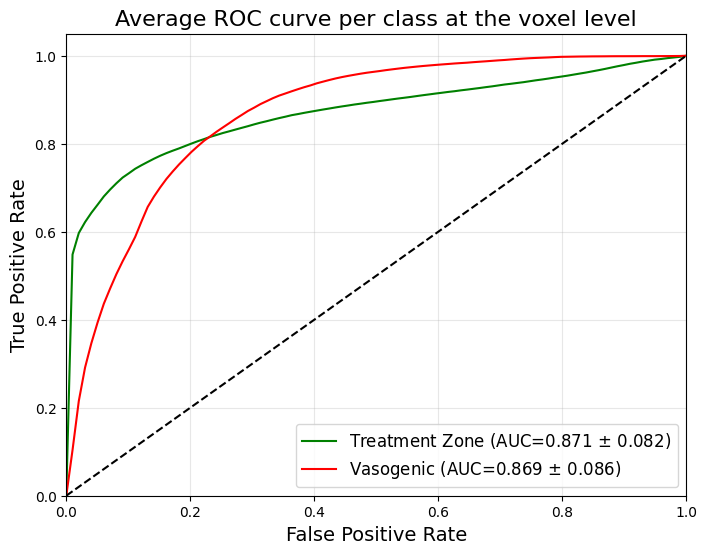

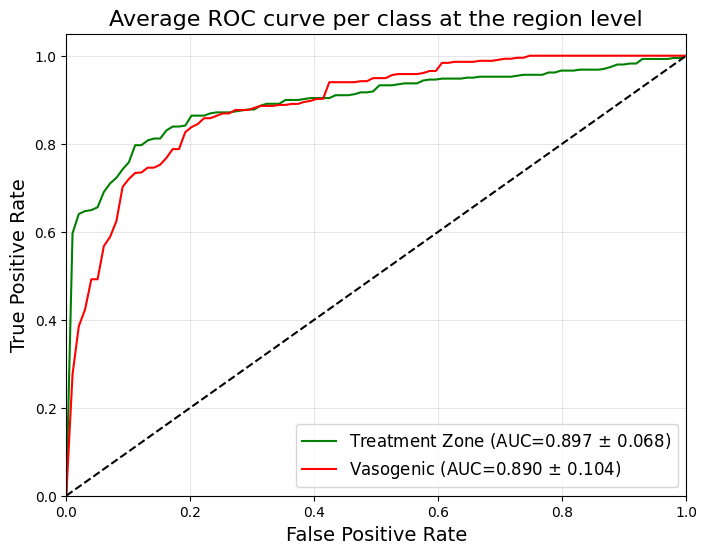

In [4]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score, f1_score
from scipy import stats
import os
import numpy as np
import nibabel as nib
import torch

# ==========================================
# 1. FUNCIONES AUXILIARES
# ==========================================

def calculate_segmentation_metrics(pred, true, num_classes=3):
    """
    Calcula métricas de segmentación (Dice, Sensibilidad, Precisión, F1)
    sobre el VOLUMEN COMPLETO (incluyendo fondo).
    """
    dice_scores = []
    sensitivity_scores = []
    precision_scores = []
    f1_scores = []
    
    for cls in range(num_classes):
        pred_cls = (pred == cls).astype(np.uint8)
        true_cls = (true == cls).astype(np.uint8)
        
        tp = np.sum(pred_cls * true_cls)
        fp = np.sum(pred_cls * (1 - true_cls))
        fn = np.sum((1 - pred_cls) * true_cls)
        
        # Dice Score
        dice = 2 * tp / (2 * tp + fp + fn + 1e-6)
        dice_scores.append(dice)
        
        # Sensibilidad (Recall)
        sensitivity = tp / (tp + fn + 1e-6)
        sensitivity_scores.append(sensitivity)
        
        # Precisión
        precision = tp / (tp + fp + 1e-6)
        precision_scores.append(precision)
        
        # F1 Score
        f1 = f1_score(true_cls.flatten(), pred_cls.flatten(), zero_division=0)
        f1_scores.append(f1)
        
    return dice_scores, sensitivity_scores, precision_scores, f1_scores

def calculate_discriminative_roi_metrics(y_true, y_pred, y_probs_map, num_classes=3):
    """
    Calcula Accuracy y AUC/ROC restringido a la ROI de LESIÓN.
    La ROI se define como la unión de las clases 1 y 2 del Ground Truth.
    """
    # 1. Definir ROI: Unión de clases Infiltración (1) y Vasogénico (2)
    roi_mask = (y_true == 1) | (y_true == 2)
    
    auc_list = [np.nan] * num_classes
    fpr_list = [np.nan] * num_classes
    tpr_list = [np.nan] * num_classes
    accuracy_val = np.nan
    
    # Si hay lesión en el GT
    if np.sum(roi_mask) > 0:
        # Extraer datos dentro de la ROI
        roi_true = y_true[roi_mask]
        roi_pred = y_pred[roi_mask]
        
        # Calcular Accuracy discriminativa (Qué tan bien distingue 1 de 2)
        accuracy_val = accuracy_score(roi_true, roi_pred)
        
        # Calcular AUC por clase (Solo para 1 y 2)
        # Se indexa el mapa de probabilidades: [Clases, N_elementos_en_ROI]
        roi_probs = y_probs_map[:, roi_mask] 
        
        for cls in [1, 2]:
            # Binarizar: Clase actual vs La otra clase de lesión
            # (Ej: Infiltración=1 vs Vasogénico=0, ignorando fondo)
            bin_true = (roi_true == cls).astype(np.uint8)
            bin_score = roi_probs[cls]
            
            # Solo calculamos si hay al menos una instancia de cada clase o variación
            if len(np.unique(bin_true)) > 1:
                auc_list[cls] = roc_auc_score(bin_true, bin_score)
                fpr, tpr, _ = roc_curve(bin_true, bin_score)
                fpr_list[cls] = fpr
                tpr_list[cls] = tpr
                
    return accuracy_val, auc_list, fpr_list, tpr_list

def get_cube_data(volume, prob_maps, cube_size, num_classes=3):
    """
    Transforma volúmenes de vóxeles a cubos (Region-wise).
    - Labels: Moda del cubo.
    - Probs: Promedio del cubo.
    """
    dims = volume.shape
    n_x, n_y, n_z = dims[0] // cube_size, dims[1] // cube_size, dims[2] // cube_size
    
    cube_labels = np.zeros((n_x, n_y, n_z), dtype=np.uint8)
    cube_probs = np.zeros((num_classes, n_x, n_y, n_z))
    
    for i in range(n_x):
        for j in range(n_y):
            for k in range(n_z):
                # Extraer sub-volumen (cubo)
                sl_x = slice(i*cube_size, (i+1)*cube_size)
                sl_y = slice(j*cube_size, (j+1)*cube_size)
                sl_z = slice(k*cube_size, (k+1)*cube_size)
                
                vol_cube = volume[sl_x, sl_y, sl_z]
                prob_cube = prob_maps[:, sl_x, sl_y, sl_z]
                
                # Etiqueta: Moda
                mode_res = stats.mode(vol_cube.flatten(), keepdims=True)
                cube_labels[i, j, k] = mode_res.mode[0]
                
                # Probabilidad: Media
                for cls in range(num_classes):
                    cube_probs[cls, i, j, k] = np.mean(prob_cube[cls])
                    
    return cube_labels, cube_probs

def get_center_distance(pred_mask, true_mask, target_class=1):
    """Calcula distancia euclidiana entre centros de masa de la clase objetivo."""
    p_mask = (pred_mask == target_class)
    t_mask = (true_mask == target_class)
    
    if np.sum(p_mask) == 0 or np.sum(t_mask) == 0:
        return np.nan
        
    p_center = np.mean(np.where(p_mask), axis=1)
    t_center = np.mean(np.where(t_mask), axis=1)
    
    return np.linalg.norm(p_center - t_center)

# ==========================================
# 2. INICIALIZACIÓN
# ==========================================

# Voxel-wise Storage
metrics_voxel = {
    'dice': {0:[], 1:[], 2:[]},
    'sens': {0:[], 1:[], 2:[]},
    'prec': {0:[], 1:[], 2:[]},
    'f1':   {0:[], 1:[], 2:[]},
    'auc':  {0:[], 1:[], 2:[]}, # ROI-based
    'fpr':  {0:[], 1:[], 2:[]}, # ROI-based
    'tpr':  {0:[], 1:[], 2:[]}, # ROI-based
    'acc':  [],                 # ROI-based
    'dist': []
}

# Cube-wise Storage
metrics_cube = {
    'dice': {0:[], 1:[], 2:[]},
    'sens': {0:[], 1:[], 2:[]},
    'prec': {0:[], 1:[], 2:[]},
    'f1':   {0:[], 1:[], 2:[]},
    'auc':  {0:[], 1:[], 2:[]}, # ROI-based
    'fpr':  {0:[], 1:[], 2:[]}, # ROI-based
    'tpr':  {0:[], 1:[], 2:[]}, # ROI-based
    'acc':  [],                 # ROI-based
    'dist': []
}

cube_size = 8  # Tamaño del cubo

# ==========================================
# 3. BUCLE DE PROCESAMIENTO
# ==========================================
print(f"Iniciando evaluación completa (Voxel & Cube size {cube_size})...")

for idx, ((embeddings1, labels1), (embeddings2, labels2)) in enumerate(zip(loader_model1, loader_model2)):
    
    # --- A. Preparar Mapas ---
    prob_maps1 = generate_probability_maps(embeddings1, projection_head1, classifier1, device)
    prob_maps2 = generate_probability_maps(embeddings2, projection_head2, classifier2, device)
    
    # Combinar mapas: (Pipe1 y Pipe2)
    # - Clase 0: del modelo 1
    # - Clase 1: máximo entre ambos modelos
    # - Clase 2: del modelo 2

    # Pipe1 + Pipe2
    combined_prob_maps = torch.zeros_like(prob_maps1)  # [3, 128, 128, 128]
    combined_prob_maps[0] = prob_maps1[0]  # Clase 0 del modelo 1
    combined_prob_maps[1] = torch.max(prob_maps1[1], prob_maps2[1])  # Clase 1 máximo entre ambos
    combined_prob_maps[2] = prob_maps2[2]  # Clase 2 del modelo 2

    # Normalizar probabilidades para que sumen 1 en cada vóxel
    # combined_prob_maps = combined_prob_maps / combined_prob_maps.sum(dim=0, keepdim=True)

    # # Solo Pipe1
    # combined_prob_maps = prob_maps1

    # # Solo Pipe2
    # combined_prob_maps = prob_maps2
    
    # Numpy Conversions
    prob_maps_np = combined_prob_maps.cpu().numpy() # [3, D, H, W]
    prob_nifti = np.transpose(prob_maps_np, (1, 2, 3, 0)) # [D, H, W, 3] para guardar
    
    segmentation_np = np.argmax(prob_maps_np, axis=0).astype(np.uint8)
    labels_np = labels2.squeeze(0).cpu().numpy().astype(np.uint8)
    
    # ------------------------------------------------
    # NIVEL 1: VOXEL-WISE
    # ------------------------------------------------
    
    # 1.1 Métricas de Segmentación (Globales)
    d, s, p, f = calculate_segmentation_metrics(segmentation_np, labels_np)
    
    # 1.2 Métricas Discriminativas (ROI de Lesión)
    acc_roi, auc_roi, fpr_roi, tpr_roi = calculate_discriminative_roi_metrics(
        labels_np, segmentation_np, prob_maps_np
    )
    
    # 1.3 Distancia Espacial
    dist_v = get_center_distance(segmentation_np, labels_np, target_class=1)
    
    # 1.4 Guardar Voxel Metrics
    metrics_voxel['acc'].append(acc_roi)
    metrics_voxel['dist'].append(dist_v)
    for c in range(3):
        metrics_voxel['dice'][c].append(d[c])
        metrics_voxel['sens'][c].append(s[c])
        metrics_voxel['prec'][c].append(p[c])
        metrics_voxel['f1'][c].append(f[c])
        metrics_voxel['auc'][c].append(auc_roi[c])
        metrics_voxel['fpr'][c].append(fpr_roi[c])
        metrics_voxel['tpr'][c].append(tpr_roi[c])

    # 1.5 Plot ROC Voxel (Individual Case)
    plt.figure(figsize=(6, 5))
    for c in [1, 2]:
        if not np.isnan(auc_roi[c]):
            plt.plot(fpr_roi[c], tpr_roi[c], label=f'Class {c} (AUC={auc_roi[c]:.2f})')
    plt.plot([0,1],[0,1], 'k--')
    plt.title(f'Voxel ROC (Lesion ROI) - Case {idx}')
    plt.legend()
    plt.savefig(os.path.join(output_dir, f"roc_voxel_case_{idx}.png"))
    plt.close()

    # ------------------------------------------------
    # NIVEL 2: CUBE-WISE (REGION-BASED)
    # ------------------------------------------------
    
    # 2.1 Transformar a Cubos
    cube_labels, cube_probs = get_cube_data(labels_np, prob_maps_np, cube_size)
    cube_preds = np.argmax(cube_probs, axis=0).astype(np.uint8)
    
    # 2.2 Métricas de Segmentación Cubos (Globales)
    dc, sc, pc, fc = calculate_segmentation_metrics(cube_preds, cube_labels)
    
    # 2.3 Métricas Discriminativas Cubos (ROI de Lesión)
    acc_roi_c, auc_roi_c, fpr_roi_c, tpr_roi_c = calculate_discriminative_roi_metrics(
        cube_labels, cube_preds, cube_probs
    )
    
    # 2.4 Distancia Espacial Cubos
    dist_c = get_center_distance(cube_preds, cube_labels, target_class=1)
    # Escalar distancia de cubos a mm reales (aprox) si se desea, o dejar en unidades de cubo
    # Aquí lo dejamos en unidades de cubo para comparar con la lógica de región
    
    # 2.5 Guardar Cube Metrics
    metrics_cube['acc'].append(acc_roi_c)
    metrics_cube['dist'].append(dist_c)
    for c in range(3):
        metrics_cube['dice'][c].append(dc[c])
        metrics_cube['sens'][c].append(sc[c])
        metrics_cube['prec'][c].append(pc[c])
        metrics_cube['f1'][c].append(fc[c])
        metrics_cube['auc'][c].append(auc_roi_c[c])
        metrics_cube['fpr'][c].append(fpr_roi_c[c])
        metrics_cube['tpr'][c].append(tpr_roi_c[c])
        
    # 2.6 Plot ROC Cube (Individual Case)
    plt.figure(figsize=(6, 5))
    for c in [1, 2]:
        if not np.isnan(auc_roi_c[c]):
            plt.plot(fpr_roi_c[c], tpr_roi_c[c], linestyle='--', label=f'Class {c} (AUC={auc_roi_c[c]:.2f})')
    plt.plot([0,1],[0,1], 'k--')
    plt.title(f'Cube ROC (Lesion ROI) - Case {idx}')
    plt.legend()
    plt.savefig(os.path.join(output_dir, f"roc_cube_case_{idx}.png"))
    plt.close()
    
    # --- Guardar Archivos NIfTI (Opcional) ---
    # Crear imágenes NIfTI
    affine = np.eye(4)
    nib.save(nib.Nifti1Image(prob_nifti, affine), os.path.join(output_dir, f"prob_case_{idx}.nii.gz"))
    nib.save(nib.Nifti1Image(segmentation_np, affine), os.path.join(output_dir, f"seg_voxel_case_{idx}.nii.gz"))
    
    # Guardar Cubos (Ajustar affine para visualización correcta)
    affine_cube = affine.copy()
    affine_cube[:3, :3] *= cube_size
    nib.save(nib.Nifti1Image(cube_preds, affine_cube), os.path.join(output_dir, f"seg_cube_case_{idx}.nii.gz"))
    
    print(f"Caso {idx} Procesado. Dice Inf Voxel: {d[1]:.3f} | Dice Inf Cube: {dc[1]:.3f}")

# ==========================================
# 4. REPORTES Y GRÁFICOS FINALES
# ==========================================

def print_summary(metrics_dict, label):
    print(f"\n{'='*20} {label} REPORT {'='*20}")
    cls_names = ['Background', 'Treatment Zone', 'Vasogenic']
    
    for c in range(3):
        print(f"\n--- Clase: {cls_names[c]} ---")
        d_m = np.nanmean(metrics_dict['dice'][c])
        s_m = np.nanmean(metrics_dict['sens'][c])
        p_m = np.nanmean(metrics_dict['prec'][c])
        
        print(f"Dice: {d_m:.4f} ± {np.nanstd(metrics_dict['dice'][c]):.4f}")
        print(f"Sens: {s_m:.4f} ± {np.nanstd(metrics_dict['sens'][c]):.4f}")
        print(f"Prec: {p_m:.4f} ± {np.nanstd(metrics_dict['prec'][c]):.4f}")
        
        if c > 0: # Solo imprimir AUC para lesiones
            auc_m = np.nanmean(metrics_dict['auc'][c])
            print(f"ROI AUC: {auc_m:.4f} ± {np.nanstd(metrics_dict['auc'][c]):.4f}")
            
    print(f"\nGlobal ROI Accuracy: {np.nanmean(metrics_dict['acc']):.4f}")
    print(f"Center Distance: {np.nanmean(metrics_dict['dist']):.4f}")

def plot_average_roc(metrics_dict, filename, title):
    plt.figure(figsize=(8, 6))
    colors = ['gray', 'green', 'red']
    classes = ['Background', 'Treatment Zone', 'Vasogenic']
    mean_fpr = np.linspace(0, 1, 100)
    
    # Solo graficamos clases 1 y 2
    for c in [1, 2]:
        tprs = []
        aucs = []
        for i in range(len(metrics_dict['fpr'][c])):
            fpr_i = metrics_dict['fpr'][c][i]
            tpr_i = metrics_dict['tpr'][c][i]
            
            # Verificar si hay datos válidos
            if isinstance(fpr_i, np.ndarray) and len(fpr_i) > 1:
                tpr_interp = np.interp(mean_fpr, fpr_i, tpr_i)
                tpr_interp[0] = 0.0
                tprs.append(tpr_interp)
                aucs.append(metrics_dict['auc'][c][i])
        
        if len(tprs) > 0:
            mean_tpr = np.mean(tprs, axis=0)
            mean_tpr[-1] = 1.0
            mean_auc = np.nanmean(aucs)
            std_auc = np.nanstd(aucs)
            plt.plot(mean_fpr, mean_tpr, color=colors[c], 
                     label=f'{classes[c]} (AUC={mean_auc:.3f} $\pm$ {std_auc:.3f})')
    
    title_fs = 16
    label_fs = 14
    legend_fs = 12

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0, 1])
    plt.ylim([0, 1.05])
    plt.title(title, fontsize=title_fs)
    plt.grid(True, alpha=0.3)
    plt.xlabel('False Positive Rate', fontsize=label_fs)
    plt.ylabel('True Positive Rate', fontsize=label_fs)
    plt.legend(loc="lower right", fontsize=legend_fs)

    plt.savefig(os.path.join(output_dir, filename))
    plt.show()

# Imprimir Resúmenes
print_summary(metrics_voxel, "VOXEL-WISE")
print_summary(metrics_cube, f"CUBE-WISE (Size {cube_size})")

# Graficar Curvas Promedio
plot_average_roc(metrics_voxel, "average_roc_voxel.png", "Average ROC curve per class at the voxel level")
plot_average_roc(metrics_cube, "average_roc_cube.png", f"Average ROC curve per class at the region level")